# CT Scan plots

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
import pathlib

PROJECT_ROOT = pathlib.Path().cwd().parent
sys.path.append(str(PROJECT_ROOT))

image_path = PROJECT_ROOT / 'ReMIND2Reg_dataset' / 'imagesTr'

from src.utils import *
from src.impedance import *
from src.datatype import MRIDataset, iUSDataset
from src.renderer import *
from src.cone import *
from src.impedance import ImpedanceEstimator

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nibabel as nib
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.cluster import KMeans
import cv2

print(torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

2.7.1+cu118
CUDA available: True
CUDA version: 11.8
GPU name: NVIDIA GeForce RTX 3050 Laptop GPU


In [4]:
patient_id = "003" # between 000 and 102, t1 and t2 don't exist for all patients
iUS_file = f"ReMIND2Reg_0{patient_id}_0000.nii.gz"
t1_file = f"ReMIND2Reg_0{patient_id}_0001.nii.gz"
t2_file = f"ReMIND2Reg_0{patient_id}_0002.nii.gz"

# Load with nibabel; each img is a Nifti1Image object
us_img = nib.load(str(image_path / iUS_file))
t1_img = nib.load(str(image_path / t1_file))
t2_img = nib.load(str(image_path / t2_file))

# Extract data arrays (as NumPy) and affines
US_vol = us_img.get_fdata(dtype=np.float32)
US_affine = us_img.affine
T1_vol = t1_img.get_fdata(dtype=np.float32)
T1_affine = t1_img.affine
T2_vol = t2_img.get_fdata(dtype=np.float32)
T2_affine = t2_img.affine

In [5]:
import numpy as np

ct_path = PROJECT_ROOT / 'additional_data' / 'CT_scan'
vivek_ct = "ctLung.nii.gz"

vivek_ct_img = nib.load(str(ct_path / vivek_ct))
vivek_ct_vol = vivek_ct_img.get_fdata(dtype=np.float32)
vivek_ct_affine = vivek_ct_img.affine

# Schneider calibration data (HU and corresponding rho values)
HU_vals = np.array([
    930, 1055, 1037, 1003, 1003, 1050, 1023, 1055, 1043, 1053,
    1044, 259, 1028, 1042, 1045, 1032, 1098, 1014, 1260, 958,
    1075, 1054, 1032, 1040, 2376, 1903, 1499, 1683, 2006, 1595,
    1763, 1413, 1260, 1609, 1477
])
rho_vals = np.array([
    0.95, 1.06, 1.04, 1.02, 1.00, 1.07, 1.03, 1.06, 1.05, 1.06,
    1.05, 0.26, 1.03, 1.05, 1.05, 1.04, 1.10, 1.03, 1.18, 0.98,
    1.09, 1.06, 1.04, 1.05, 1.92, 1.61, 1.33, 1.46, 1.68, 1.41,
    1.52, 1.29, 1.18, 1.42, 1.33
]) * 1000  # Convert from g/cm³ to kg/m³

# Sort calibration data for interpolation
sorted_indices = np.argsort(HU_vals)
H_sorted = HU_vals[sorted_indices]
rho_sorted = rho_vals[sorted_indices]

# Coefficients from Webb's 120 kVp standard kernel fit: c(HU) = a * HU + b
# _a, _b = 0.38, 1450  # speed of sound model from Webb (m/s)
_a, _b = 0.98, 1240  # speed of sound model from Webb (m/s)

# Interpolated density from HU
def rho_pw(hu):
    return np.interp(hu, H_sorted, rho_sorted,
                     left=rho_sorted[0], right=rho_sorted[-1])

# Speed of sound as function of HU
def c(hu):
    return _a * np.asarray(hu) + _b

# Full impedance model
def Z(hu):
    return rho_pw(hu)*c(hu)

Z_vivek = Z(vivek_ct_vol + 1000)  # Add 1000 to shift to clinical HU scale
Z_vivek_2 = 1000 * (1540 + 0.35 * vivek_ct_vol) + vivek_ct_vol * (1540 + 0.35 * vivek_ct_vol)

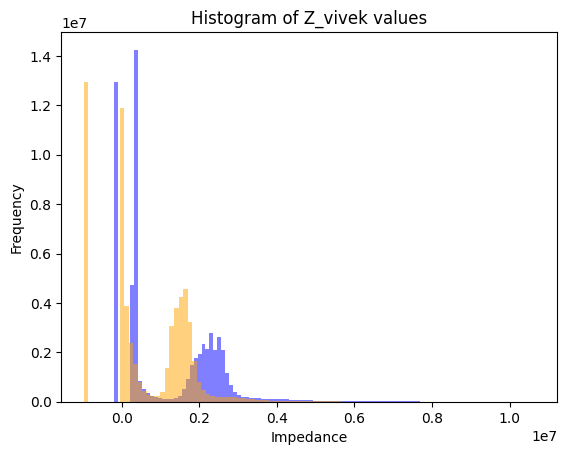

In [274]:
plt.hist(Z_vivek.flatten(), bins=100, color='blue', alpha=0.5, label='Formal Z_vivek')
plt.hist(Z_vivek_2.flatten(), bins=100, color='orange', alpha=0.5, label='BS Z_vivek_2')
plt.xlabel("Impedance")
plt.ylabel("Frequency")
plt.title("Histogram of Z_vivek values")
plt.show()

In [275]:
slice = 100
x0, y0 = 140, 360
direction_vec_2d = direction_vec = np.array([ 0.34467694, -0.93872137])
# mask_ct = overlay_cone(noe_ct_vol[:,:,slice], apex=np.array([x0, y0]), direction_vector=direction_vec_2d, opening_angle=opening_angle)
# plot_overlay_cone(noe_ct_vol[:,:,slice], mask_ct)

In [276]:
start = 0
n_rays = 64
dx, dy = direction_vec_2d
direction_vec = np.array([dx, dy, slice])
source = np.array([x0, y0, slice])
directions = generate_cone_directions(direction_vec, opening_angle, n_rays)


# Brain, Noé DICOM file conveted to NIfTI

In [708]:
# Z = (1000 + noe_ct_vol ) * 1540
# Z_noe = 1000 * (1540 + 0.35 * noe_ct_vol) + noe_ct_vol * (1540 + 0.35 * noe_ct_vol)

In [709]:
# renderer = UltrasoundRenderer(num_samples=228, attenuation_coeff=0.0001)
# x,z,intensities = renderer.plot_beam_frame(
#             volume=torch.tensor(Z_noe),
#             source=torch.tensor(source),
#             directions=torch.tensor(directions),
#             angle=0,
#             plot=False,
#             artifacts=False,
#             start=start
#         )

In [710]:
# H, W = noe_ct_vol[:,:,slice].shape[:2]
# synth_img = differentiable_splat(x, z, intensities, H=H, W=W, sigma=0.5)
# plt.imshow(synth_img, cmap='gray', origin="lower")

# Chest, vivek volume

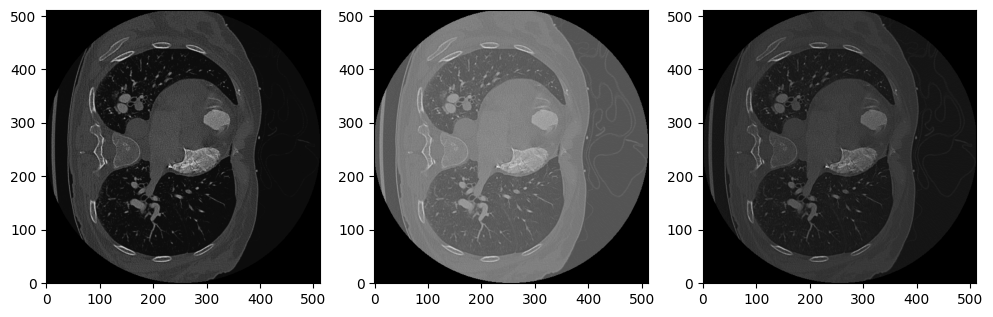

In [277]:
fig, ax = plt.subplots(1, 3, figsize=(12, 6))
ax[0].imshow(Z_vivek[:, :, slice], cmap='gray', origin='lower')
ax[1].imshow(vivek_ct_vol[:, :, slice], cmap='gray', origin='lower')
ax[2].imshow(Z_vivek_2[:, :, slice], cmap='gray', origin='lower')


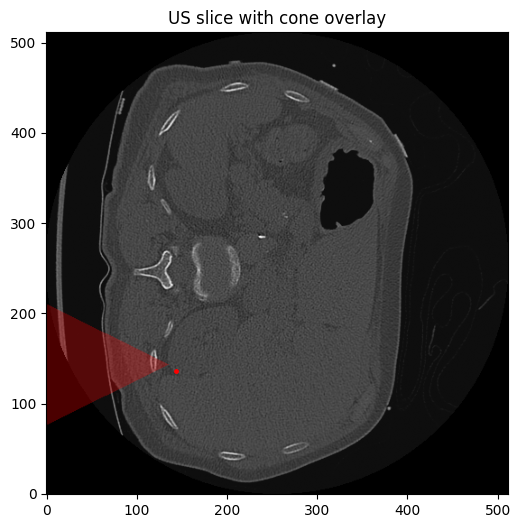

In [278]:
slice = 15
x0, y0 = 136,143
direction_vec_2d = np.array([ -1, 0])
mask_ct = overlay_cone(Z_vivek[:,:,slice], apex=np.array([x0, y0]), direction_vector=direction_vec_2d, opening_angle=opening_angle)
plot_overlay_cone(Z_vivek[:,:,slice], mask_ct)
plt.plot(y0, x0, 'r.', markersize=5)

# Front view

In [279]:
direction_vec = np.array([0,-1, slice])

print("Source:", source)
print("Directions shape:", directions.shape, "\n Direction vec:", direction_vec)


Source: [136 143  15]
Directions shape: torch.Size([64, 3]) 
 Direction vec: [ 0 -1 15]


C:\Users\noe\AppData\Local\Temp\ipykernel_59552\1796560388.py:9: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



[INFO] Tracing rays with source: tensor([490, 180, 120]) and directions shape: torch.Size([200, 1, 3])
[INFO] Visualizing sampled points in 3D volume
[INFO] Variances: x=689.7672, y=508.5974, z=0.0000


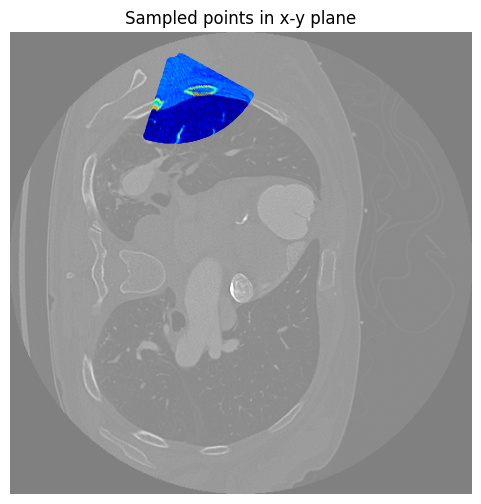

[INFO] Ray values shape: torch.Size([200, 100])
[INFO] Starting from sample index: 10 (for instance, to skip bones)
[INFO] Processed output shape: torch.Size([200, 90])
[INFO] Variances: [0.0, 582.5140380859375, 535.27294921875]
tensor(-16.2089) tensor(2.3836) tensor(-0.0063)


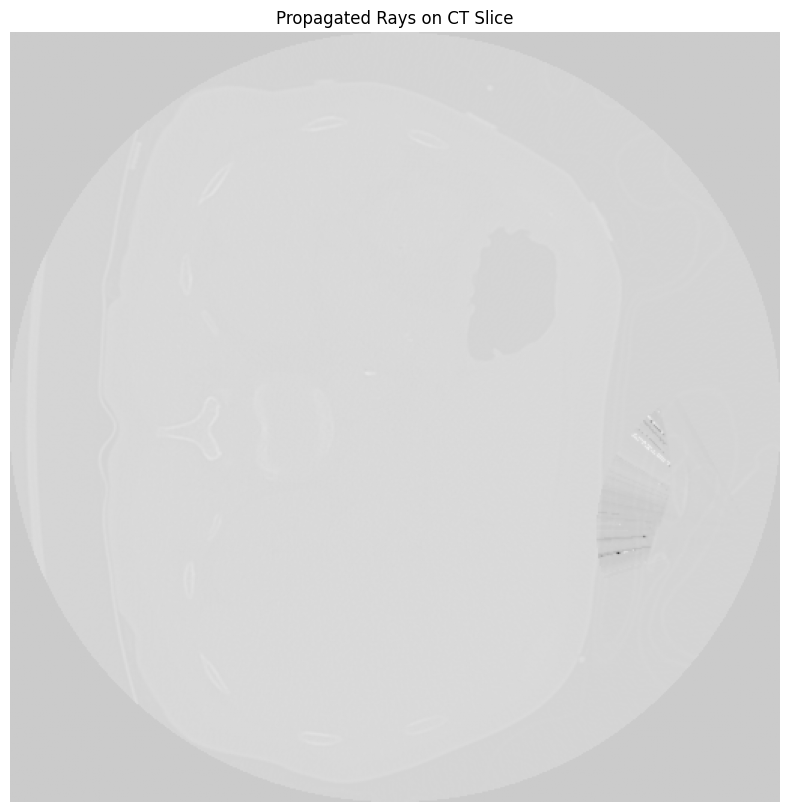

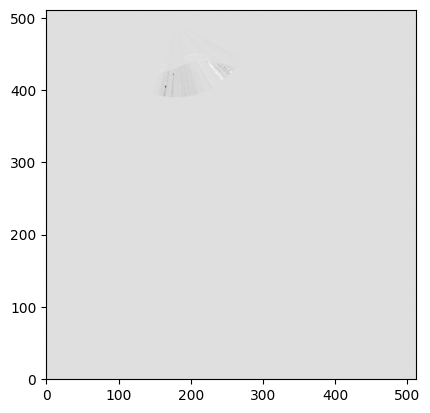

In [307]:
start = 0
n_rays = 200
renderer = UltrasoundRenderer(num_samples=100, attenuation_coeff=0.0001)
source = np.array([490, 180, 120])
directions = generate_cone_directions(torch.tensor([-1,0.4,15]), 1.5*opening_angle, n_rays)
x,y,z,intensities = renderer.plot_beam_frame(
            volume=torch.tensor(Z_vivek_2),
            source=torch.tensor(source),
            directions=torch.tensor(directions)[:, [0, 1, 2]],  # Adjust for y-axis inversion in image coordinates
            angle=25,
            plot=False,
            artifacts=False,
            start=10
)

H, W = vivek_ct_vol[:,:,slice].shape[:2]
plt.figure(figsize=(10,10))
plt.imshow(vivek_ct_vol[:,:,slice], cmap='gray', origin="lower", alpha=0.5)
synth_img = differentiable_splat(z,x,y, intensities, H=H, W=W, sigma=0.5)
print(synth_img.min(), synth_img.max(), synth_img.mean())
plt.imshow(synth_img.T, cmap='gray', origin="lower", alpha=0.8)
plt.title("Propagated Rays on CT Slice")
plt.axis('off')
plt.show()
plt.imshow(synth_img, cmap='gray', origin="lower", alpha=1)


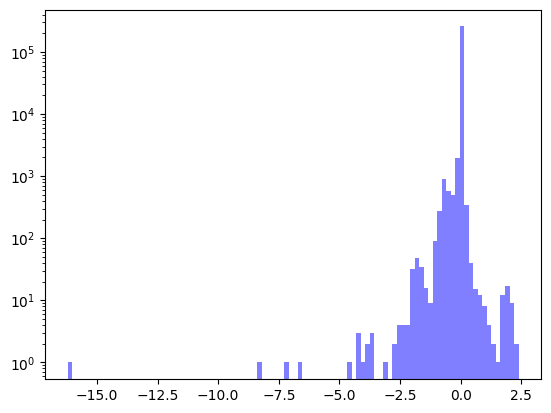

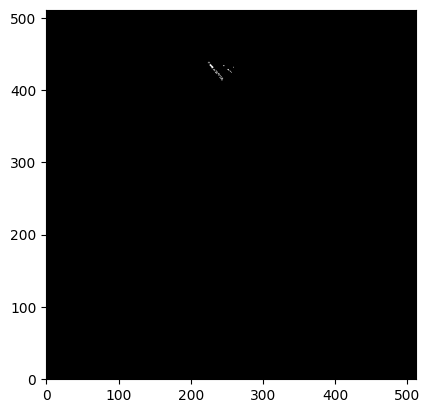

In [308]:
plt.hist(synth_img.flatten(), bins=100, color='blue', alpha=0.5, label='Synthesized Image')
plt.yscale('log')
plt.show()
plt.imshow(synth_img>1, cmap='gray', origin="lower", alpha=1)

# Side view

Source: [ 75  15 137]
Directions shape: torch.Size([200, 3]) 
 Direction vec: [ 0 -1 15] tensor([[ 0.0000,  0.8970, -0.4420],
        [ 0.0000,  0.8990, -0.4379],
        [ 0.0000,  0.9010, -0.4338],
        [ 0.0000,  0.9030, -0.4296],
        [ 0.0000,  0.9050, -0.4255],
        [ 0.0000,  0.9069, -0.4213],
        [ 0.0000,  0.9089, -0.4171],
        [ 0.0000,  0.9108, -0.4129],
        [ 0.0000,  0.9127, -0.4087],
        [ 0.0000,  0.9145, -0.4045],
        [ 0.0000,  0.9164, -0.4003],
        [ 0.0000,  0.9182, -0.3961],
        [ 0.0000,  0.9200, -0.3919],
        [ 0.0000,  0.9218, -0.3876],
        [ 0.0000,  0.9236, -0.3834],
        [ 0.0000,  0.9253, -0.3791],
        [ 0.0000,  0.9271, -0.3749],
        [ 0.0000,  0.9288, -0.3706],
        [ 0.0000,  0.9305, -0.3663],
        [ 0.0000,  0.9322, -0.3620],
        [ 0.0000,  0.9338, -0.3577],
        [ 0.0000,  0.9355, -0.3534],
        [ 0.0000,  0.9371, -0.3491],
        [ 0.0000,  0.9387, -0.3448],
        [ 0.0000,  0.94

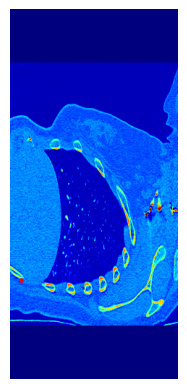

In [309]:
plt.imshow(Z_vivek[75,:,:], cmap='jet', origin="lower")
source = np.array([75, 15, 137])
direction_vec = np.array([0,-1, slice])
directions = generate_cone_directions(direction_vec, opening_angle, n_rays)
directions = directions[:, [2, 1,0]]
directions[:,1] = -directions[:,1]  # flip y-axis for correct orientation
plt.scatter(source[1], source[2], c='r', s=5)
plt.axis('off')
print("Source:", source)
print("Directions shape:", directions.shape, "\n Direction vec:", direction_vec, directions)

C:\Users\noe\AppData\Local\Temp\ipykernel_59552\813559482.py:5: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



[INFO] Tracing rays with source: tensor([136,   8,  19]) and directions shape: torch.Size([200, 1, 3])
[INFO] Visualizing sampled points in 3D volume
[INFO] Variances: x=0.0000, y=498.1853, z=125.7703


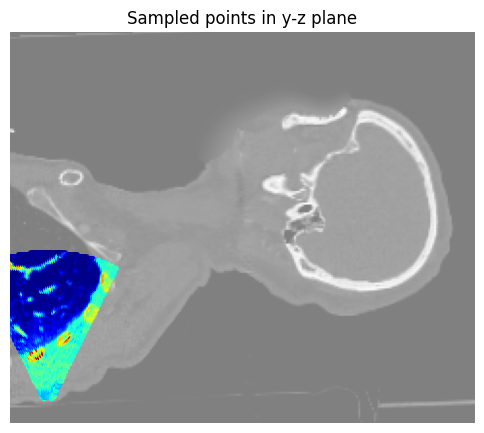

[INFO] Ray values shape: torch.Size([200, 80])
[INFO] Starting from sample index: 5 (for instance, to skip bones)
[INFO] Processed output shape: torch.Size([200, 75])
[INFO] Variances: [134.11643981933594, 0.0, 438.2960510253906]
tensor(0.) tensor(0.5030) tensor(0.0019)


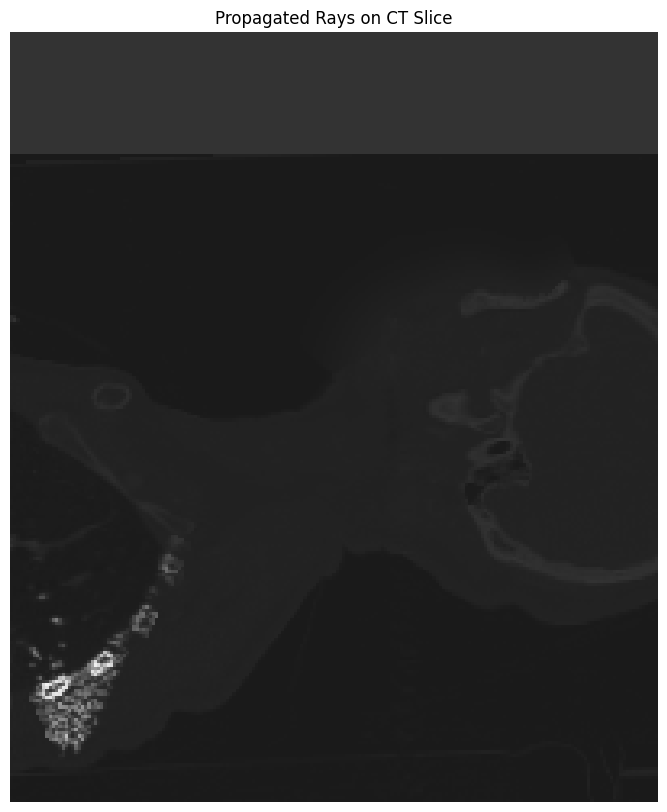

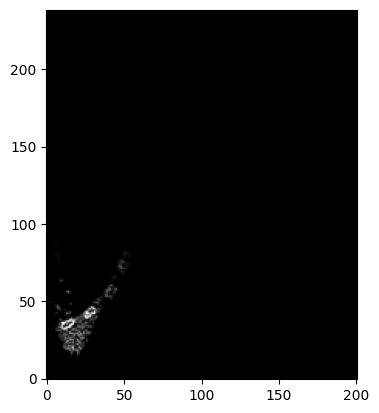

In [267]:
renderer = UltrasoundRenderer(num_samples=80, attenuation_coeff=0.0001)
x,y, z,intensities = renderer.plot_beam_frame(
            volume=torch.tensor(Z_vivek),
            source=torch.tensor([136, 8,19]),
            directions=torch.tensor(directions),
            angle=20,
            plot=False,
            artifacts=True,
            start=5
        )


H, W = vivek_ct_vol[136,:,:].shape[:2]
plt.figure(figsize=(10,10))
plt.imshow(vivek_ct_vol[136,:,:], cmap='gray', origin="lower", alpha=0.5)
synth_img = differentiable_splat(z,x,y, intensities, H=H, W=W, sigma=0.5)
print(synth_img.min(), synth_img.max(), synth_img.mean())
plt.imshow(synth_img, cmap='gray', origin="lower", alpha=0.8, vmin=0)
plt.title("Propagated Rays on CT Slice")
plt.axis('off')
plt.show()
plt.imshow(synth_img, cmap='gray', origin="lower", alpha=1)

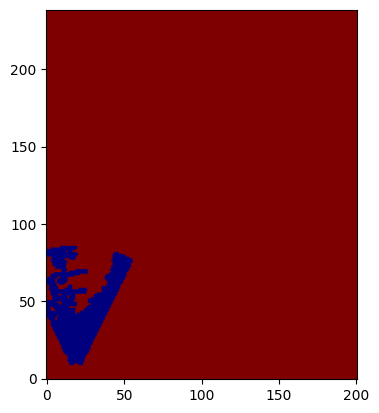

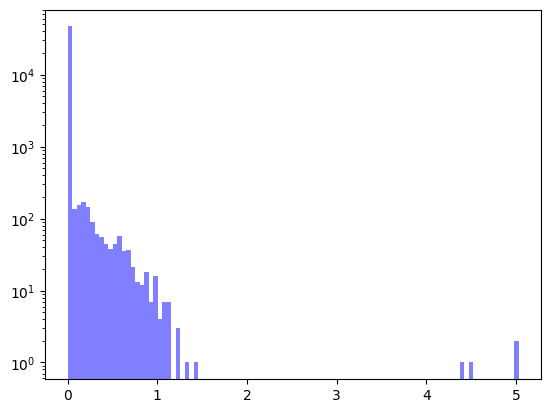

In [265]:
# plt.imshow(synth_img, cmap='gray', origin="lower", alpha=1)

plt.imshow(synth_img<1e-6, cmap='jet', origin="lower", alpha=1, vmax=0.00001)
plt.show()
plt.hist(synth_img.flatten(), bins=100, color='blue', alpha=0.5, label='Synthesized Image')
plt.yscale('log')

(np.float64(-0.5), np.float64(238.5), np.float64(-0.5), np.float64(200.5))

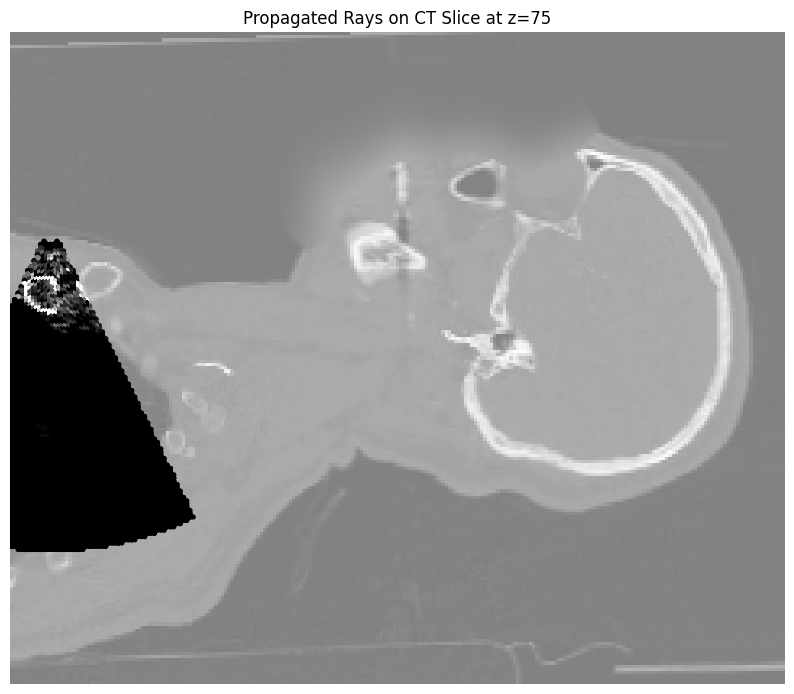

In [231]:
plt.figure(figsize=(10,10))
plt.imshow(vivek_ct_vol[75,:,:], cmap='gray', origin="lower", alpha=0.5)
plt.scatter(z, y, c=intensities, s=8, cmap='gray', alpha=1)
plt.title("Propagated Rays on CT Slice at z=75")
plt.axis('off')

# Third view

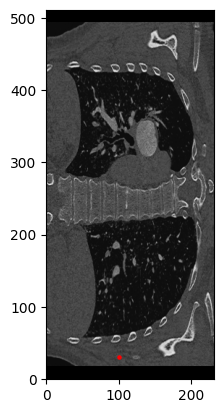

In [327]:
plt.imshow(Z_vivek[:,160,:], cmap='gray', origin="lower")
source = np.array([100, 160, 30])
plt.scatter(source[0], source[2], c='r', s=5)

In [436]:
directions = generate_cone_directions(direction_vec, opening_angle*1.2, n_rays)
directions = directions[:, [2, 1,0]]
# directions[:,1] = -directions[:,1]  # flip y-axis for correct orientation

In [437]:
directions_2 = directions[:,[1,2,0]]
directions_2[:,0] = directions_2[:,0]  # flip x-axis for correct orientation
directions_2 = torch.tensor(directions_2)[:,[0,2,1]]

C:\Users\noe\AppData\Local\Temp\ipykernel_59552\2320763023.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



In [1]:
start = 0
n_rays = 200
import time 
time_taken = 0
start = time.time()
for _ in range(10):
    renderer = UltrasoundRenderer(num_samples=100, attenuation_coeff=0.0001)
    x,y, z,intensities = renderer.plot_beam_frame(
                volume=torch.tensor(vivek_ct_vol),
                source=torch.Tensor([20, 160, 120]),
                directions=directions_2,
                angle=25,
                plot=False,
                artifacts=True,
                start=20
            )
    time_taken += time.time() - start
print(f"Time taken for rendering: {time_taken/10:.2f} seconds")
# synth_img = differentiable_splat(x,y, z, intensities, H=H, W=W, sigma=0.5)

# H, W = vivek_ct_vol[:,:,slice].shape[:2]

NameError: name 'UltrasoundRenderer' is not defined

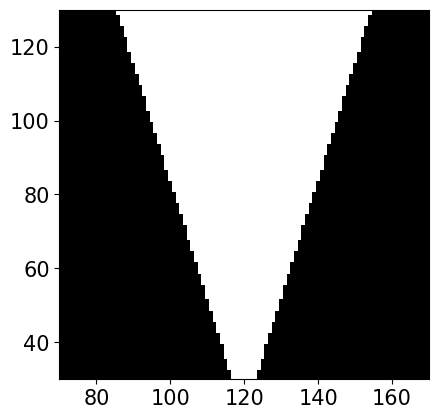

In [475]:
mask_us = overlay_cone(
    Z_vivek[:,160,:],
    apex=np.array([120,20]),  # (row, col)
    direction_vector=[0,1],  # do not reverse, keep as is
    opening_angle=opening_angle / 2 +0.15
)
plt.xlim(70, 170)
plt.ylim(30,130)
plt.imshow(mask_us, cmap='gray', origin="lower")

[INFO] Variances: [489.2598571777344, 0.0, 389.5699768066406]


Text(0.5, 1.0, 'Overlaid')

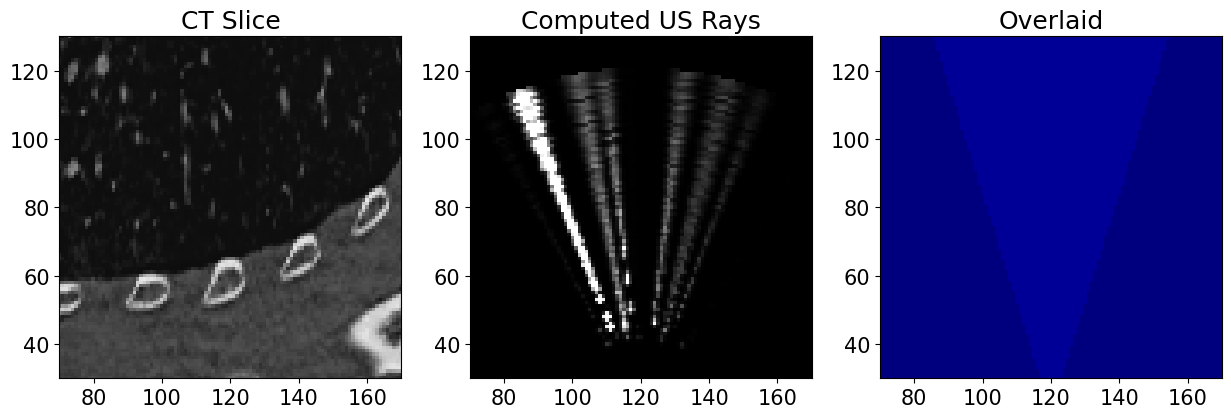

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
plt.rcParams.update({'font.size': 15})
ax[0].imshow(Z_vivek[:,160,:], cmap='gray', origin="lower", alpha=1)
ax[0].set_xlim(70, 170)
ax[0].set_ylim(30,130)
ax[0].set_title("CT Slice")

synth_img = differentiable_splat(x,y, z, intensities, H=H, W=W, sigma=0.5)
ax[1].imshow(synth_img, cmap='gray', origin="lower", alpha=1, vmin=0, vmax=10)
ax[1].set_xlim(70, 170)
ax[1].set_ylim(30,130)
ax[1].set_title("Computed US Rays")

ax[2].imshow(synth_img==0, cmap='jet', origin="lower", alpha=1, vmin=0, vmax=50)
ax[2].imshow(mask_us, cmap='jet', origin="lower", alpha=1, vmin=0, vmax=50)
ax[2].set_xlim(70, 170)
ax[2].set_ylim(30,130)
ax[2].set_title("Overlaid")

[INFO] Variances: [631.9303588867188, 0.0, 246.7220458984375]
tensor(0.) tensor(25.2999) tensor(0.0225)


(np.float64(-0.5), np.float64(511.5), np.float64(-0.5), np.float64(511.5))

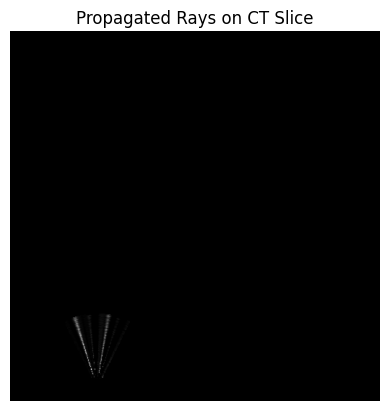

In [360]:
# plt.imshow(Z_vivek[:,:, 25], cmap='gray', origin="lower", alpha=1)
synth_img = differentiable_splat(x,y,z, intensities, H=H, W=W, sigma=0.5)
print(synth_img.min(), synth_img.max(), synth_img.mean())
plt.imshow(synth_img, cmap='gray', origin="lower", alpha=1)
plt.title("Propagated Rays on CT Slice")
plt.axis('off')
